In [29]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

TOP_LEVEL_DIR = r"G:\Volumes\portable_hard_drive\downloads"
# This just loads 50 per zip file
def load_all_hypersim_samples(top_dir, max_frames_per_subset=50):
    sample_pairs = []

    for subset_folder in os.listdir(top_dir):
        outer_path = os.path.join(top_dir, subset_folder)
        nested_path = os.path.join(outer_path, subset_folder)  # Nested folder (e.g., ai_001_001/ai_001_001)

        images_path = os.path.join(nested_path, 'images')
        if not os.path.isdir(images_path):
            print(f"[!] Skipping: {images_path} not found.")
            continue

        # Loop through all camera folders
        for cam_folder in os.listdir(images_path):
            if not cam_folder.endswith("_final_hdf5"):
                continue

            final_path = os.path.join(images_path, cam_folder)
            geom_path = os.path.join(images_path, cam_folder.replace("_final_hdf5", "_geometry_hdf5"))

            if not os.path.isdir(final_path) or not os.path.isdir(geom_path):
                continue

            # Match frame.XXXX.color.hdf5 and frame.XXXX.semantic.hdf5
            color_files = sorted([f for f in os.listdir(final_path) if f.endswith(".color.hdf5")])

            for fname in color_files[:max_frames_per_subset]:
                frame_id = fname.replace(".color.hdf5", "")
                color_fp = os.path.join(final_path, fname)
                semantic_fp = os.path.join(geom_path, f"{frame_id}.semantic.hdf5")

                if not os.path.exists(semantic_fp):
                    continue

                try:
                    with h5py.File(color_fp, 'r') as f_color, h5py.File(semantic_fp, 'r') as f_sem:
                        rgb = np.array(f_color['dataset'])
                        mask = np.array(f_sem['dataset'])
                        sample_pairs.append((rgb, mask))
                except Exception as e:
                    print(f"❌ Failed to load {frame_id} in {subset_folder}: {e}")
                    continue

    return sample_pairs

samples = load_all_hypersim_samples(TOP_LEVEL_DIR)


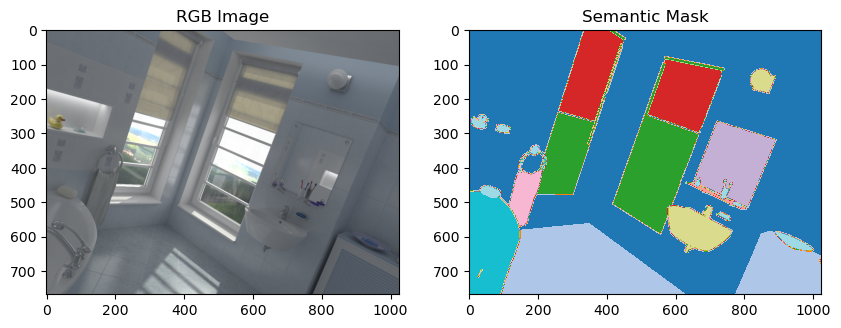

In [30]:
if samples:
    rgb_img, mask = samples[0]
    norm_factor = np.percentile(rgb_img, 99)  # images need to be normalized because they come from hdf5 format
    rgb_norm = rgb_img / norm_factor
    gamma = 2.2 # Gamma correction is needed to make the image brighter
    rgb_corrected = np.power(rgb_img / norm_factor, 1 / gamma)
    rgb_disp = (np.clip(rgb_corrected, 0, 1) * 255).astype(np.uint8)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_disp)
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.astype(np.int32), cmap='tab20')
    plt.title("Semantic Mask")
    plt.show()